# CSCI-UA 0480-042 Computer Vision
## Homework 4

Enter your name and NetID below.

#### Name: Anita Ye
#### NetID: yy3557

The main goals of this assignment include:

1. Giving an introduction to DETR
2. Visualizing attention masks at different layers of te transformer
3. Generating bounding boxes for a test image
4. Visualizing panoptic segments identified by the model


There are (**4 questions in total**). Please give your answers in the space provided. In most of the questions, you will be asked to complete a code snippet. You can quickly navigate to those questions by searching (Ctrl/Cmd-F) for `TODO:`. For questions requiring a markdown answer, navigate to them by searching `Answer`.

# 1. Introduction to DETR

DETR, or "DEtection TRansformers," is a novel object detection framework that leverages transformer architectures for the task of object detection in computer vision. It was introduced in the paper titled "End-to-End Object Detection with Transformers," presented at the European Conference on Computer Vision (ECCV) in 2020.

Key features of DETR include:

1. **End-to-End Framework:** DETR eliminates the need for separate region proposal networks and subsequent refinement stages. It directly predicts the set of objects and their corresponding bounding boxes in a single forward pass.

2. **Set Prediction:** Instead of predicting a fixed number of bounding box proposals, DETR treats object detection as a set prediction problem. The transformer outputs a fixed number of object queries, and a learnable permutation is applied to match these queries with the ground truth objects.

3. **Attention Mechanisms:** DETR utilizes self-attention mechanisms within the transformer architecture to capture global context information, allowing the model to consider relationships between different parts of the image.

4. **Positional Encodings:** As transformers do not inherently understand the spatial information of input sequences, DETR incorporates positional encodings to provide information about the absolute and relative positions of objects in the image.

In [21]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from IPython.display import display, clear_output

import torch
from torch import nn
import torchvision
import torchvision.transforms as T

torch.set_grad_enabled(False)

In [22]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [23]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [24]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## 1.1 Load the pretrained resnet50 model via torch.hub [10%]

#### You first need to set the torch.hub download path to a local dir so that it doesn't download the model in the cache

In [25]:
import os
os.getcwd()

'/home/jovyan/HW4'

In [26]:
local_path = '/home/jovyan/HW4'
torch.hub.set_dir(local_path)

In [27]:
!rm -r "$local_path""/facebookresearch_detr_main"

!rm -r "$local_path""/checkpoints"

#### Next, load the mode `detr_resnet50` under `facebookresearch/detr` using torch.hub.load

In [28]:
# TODO: Load the detr_resnet50 pretrained model
model = torch.hub.load('facebookresearch/detr','detr_resnet50',pretrained = True)
model.eval()

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /home/jovyan/HW4/main.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/HW4/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s] 
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /home/jovyan/HW4/checkpoints/detr-r50-e632da11.pth
100%|██████████| 159M/159M [00:01<00:00, 120MB/s]  


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [29]:
# TODO: Using the output of model.eval() above, identify the number of encoder and decoder layers
num_layers = 12

In [30]:
model.backbone[-2]

Backbone(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d()
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

In [31]:
matrix= model.transformer.encoder.num_layers,model.transformer.decoder.num_layers

print(f"Number of encoder layers: {matrix[0]}")
print(f"Number of decoder layers: {matrix[1]}")

Number of encoder layers: 6
Number of decoder layers: 6


## 1.2 Generating bounding boxes

#### Download an image of your choice from https://cocodataset.org/#explore [10%]

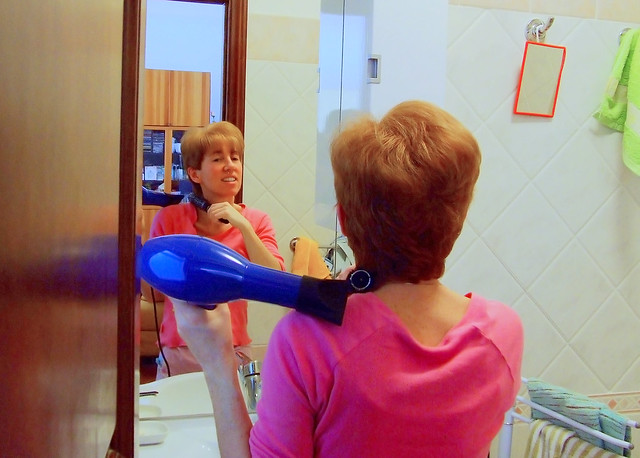

In [32]:
# TODO: Load image
img_path = "452045120_885597e865_z.jpg"
im = Image.open(img_path)
im

#### Transform image and generate output

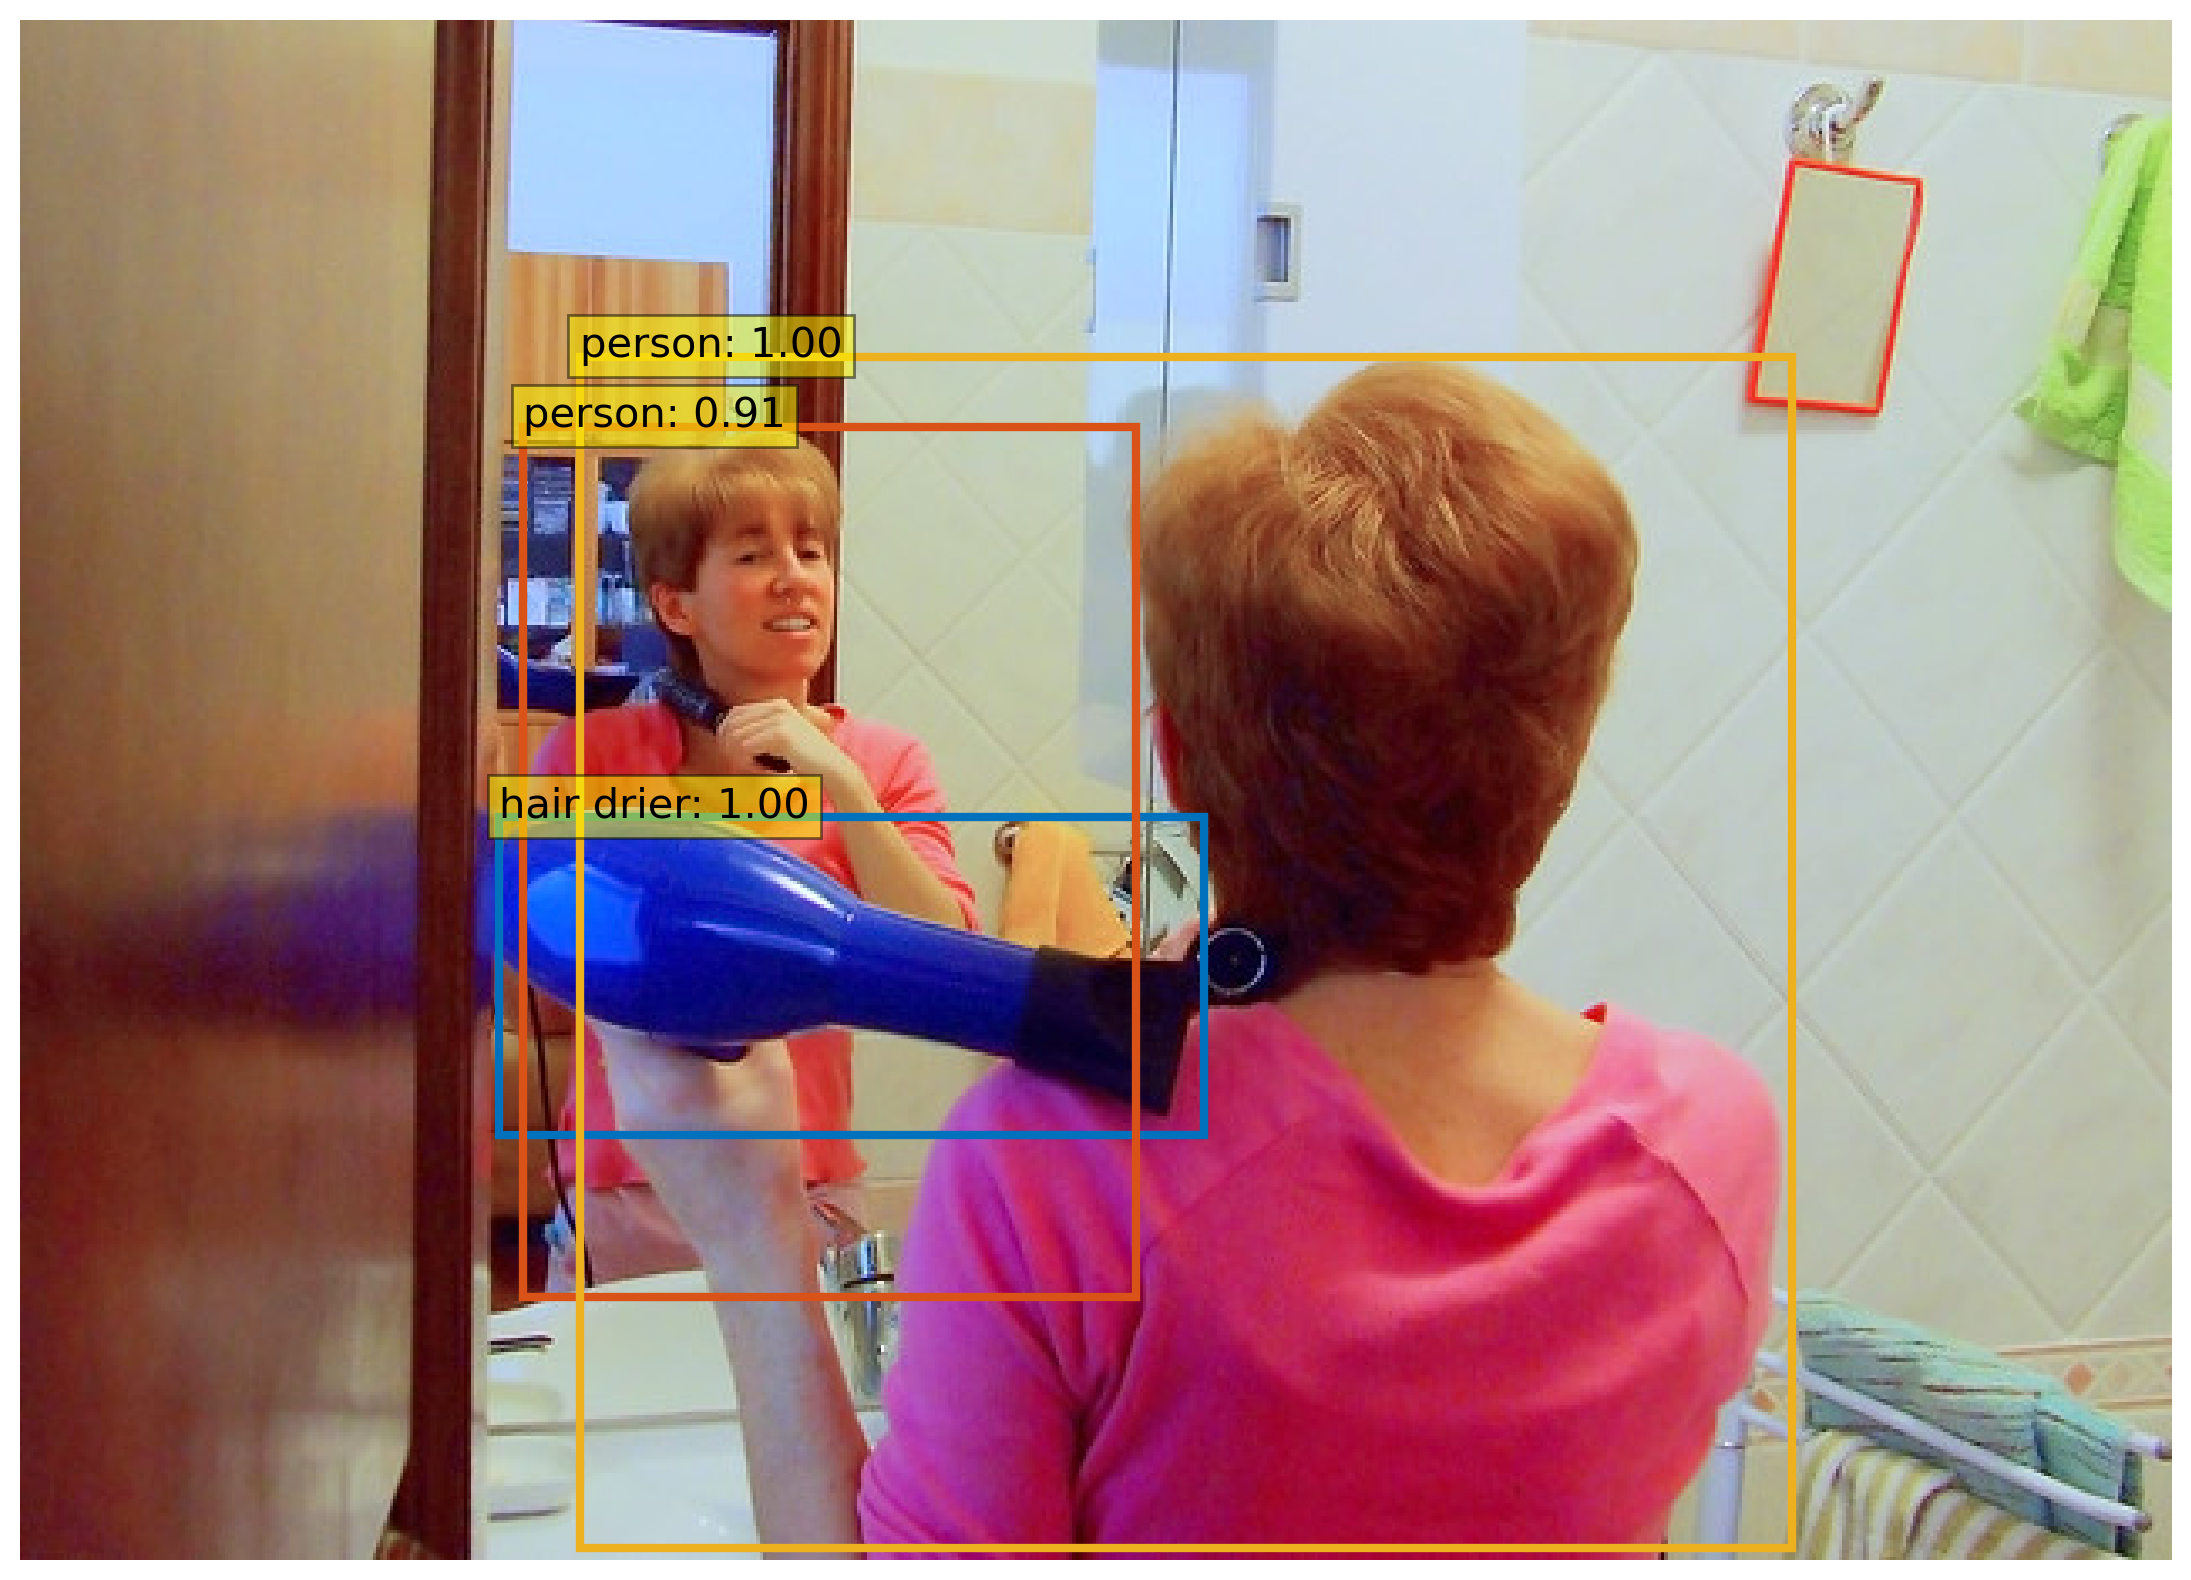

In [33]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# TODO: transform the image using the transform specified above
img = transform(im)
img = img.unsqueeze(0)

# TODO: propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

# 2. Visualizing Attention Weights

## 2.1. Using the code snippet below as a guide, visualize the encoder and decoder attention weights for each layer of the transformer [25%]

#### Use lists to store the outputs via up-values

```
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[0].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[0].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]
```

#### Propagate through the model

```
outputs = model(img)

for hook in hooks:
    hook.remove()
```

### `Note:` Remember to pop the first element from each list before plotting

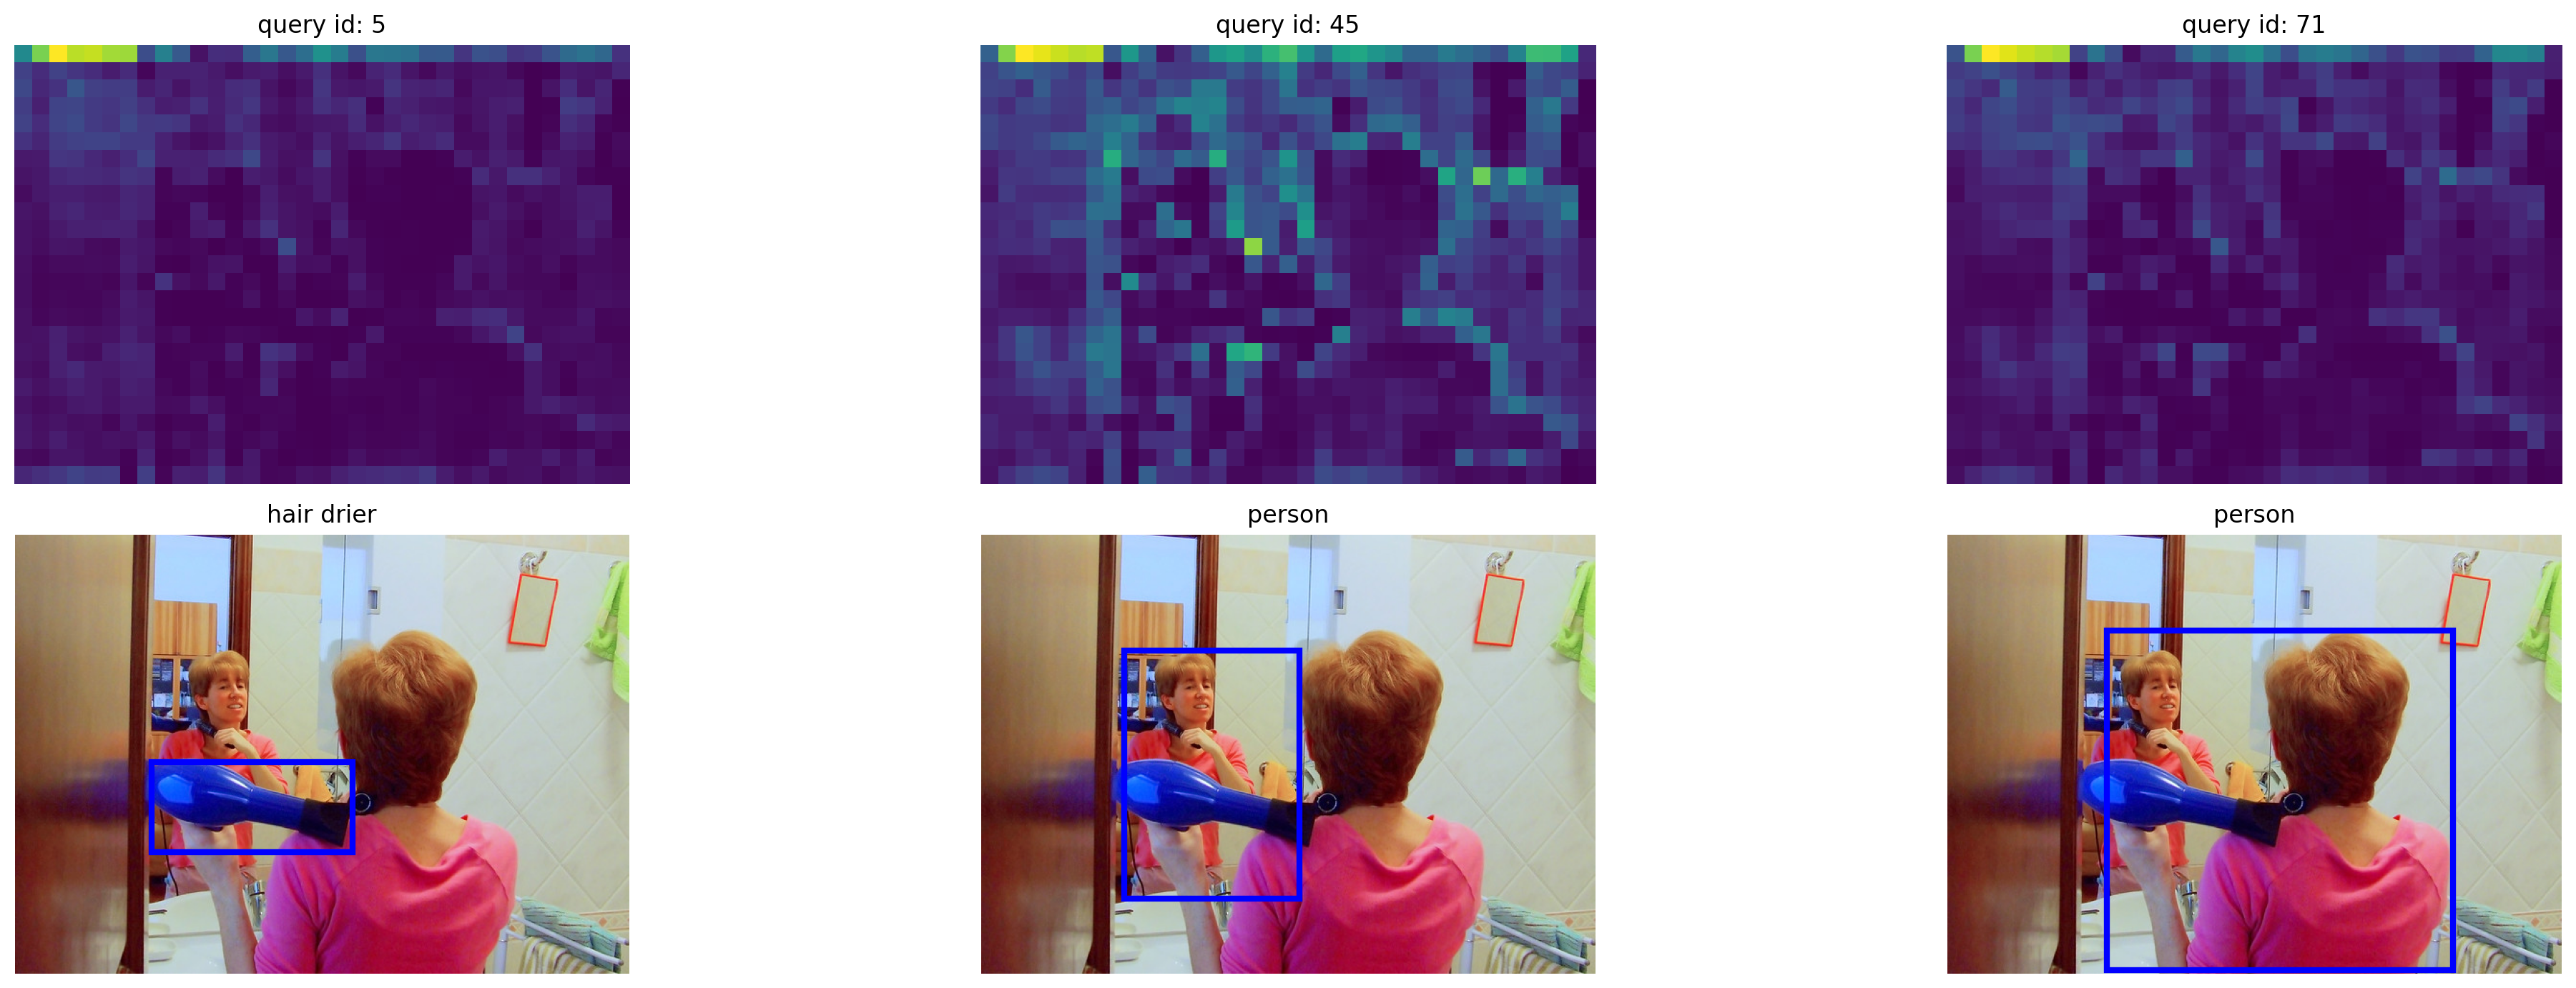

In [34]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

# TODO:
hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[0].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[0].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# TODO: propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# TODO: Pop the elements
conv_features = conv_features.pop(0) if conv_features else None
enc_attn_weights = enc_attn_weights.pop(0) if enc_attn_weights else None
dec_attn_weights = dec_attn_weights.pop(0) if dec_attn_weights else None


# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(enc_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

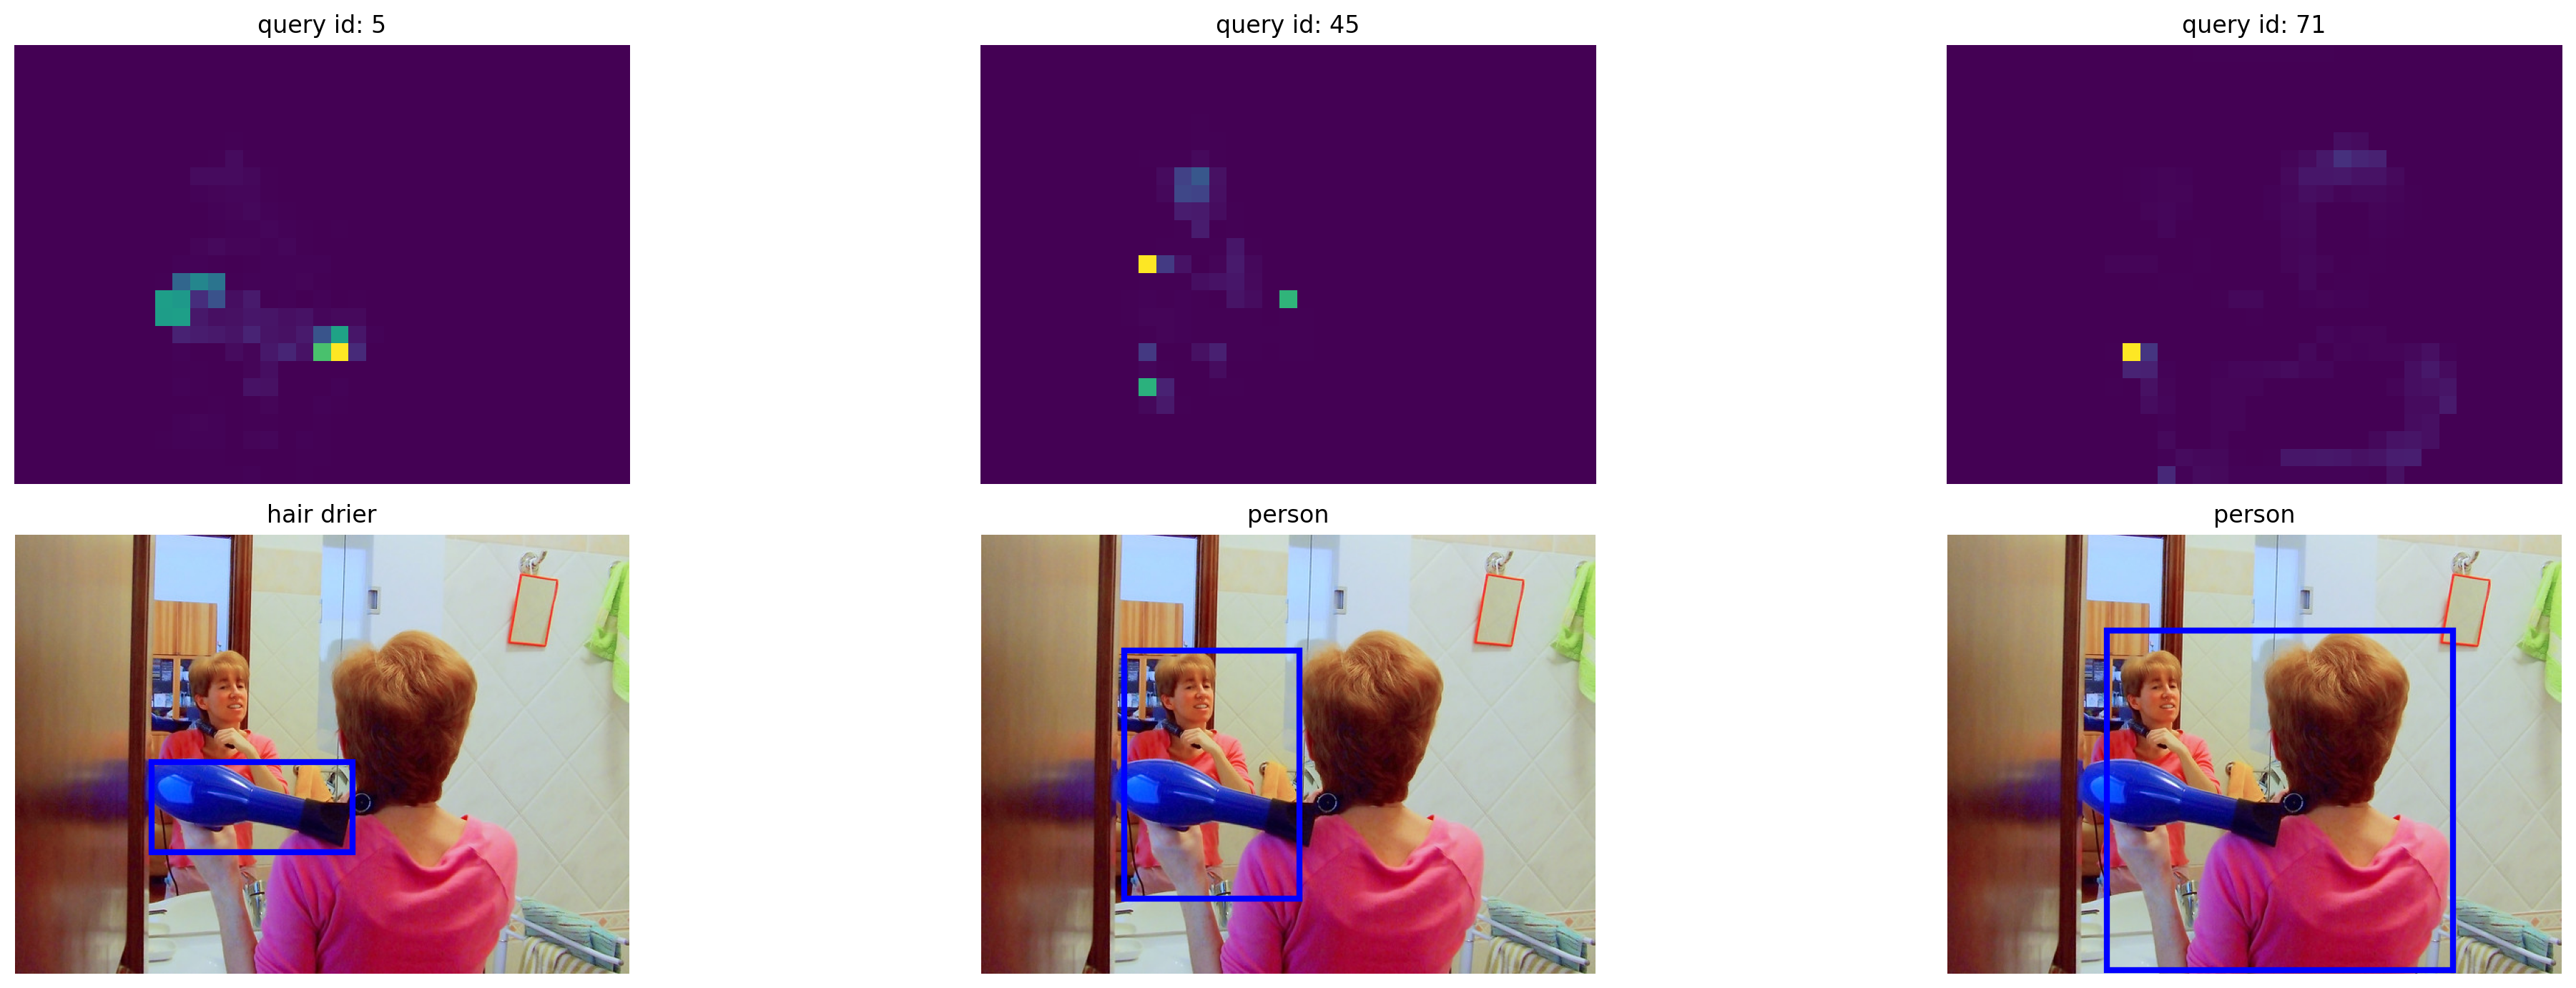

In [35]:
#plot for decoder
fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

# 2.2. What do you observe? [10%]

Write in your own words

`Answer`

The heatmap shows the attention weights, where areas of input feature map the model. The bounding box shows the objects detected, which are two people and a hair drier in this picture. The heat map's area bit blurry especially for the third picture of a larger area of person. 

The Encoder's self attention with CNN backbone on the entire picture showed that there are several objectes detected, but it is not showing the clear shape of them. Decoder's attention is more focused, showing bounding boxes of the objects detected. Its attention is combined with that of Encoder's, and is more detail-guided, and here we can see the approximate shape of each object, the two people and the hair drier. 



# 3. Using a different backbone

There is another pre-trained DETR model available with a `resnet101` backbone (`detr_resnet101`)

Similar to the `detr_resnet50` backone you used above, visualize bounding boxes and attention maps for each layer of the encoder and decoder using a `resnet101` backbone

### Before downloading resnet101 make sure to clean-up the local_path to not run out of memory

`!rm -r "$local_path""/facebookresearch_detr_main"`

`!rm -r "$local_path""/checkpoints"`

In [36]:
!rm -r "$local_path""/facebookresearch_detr_main"

!rm -r "$local_path""/checkpoints"

In [37]:
model = torch.hub.load('facebookresearch/detr','detr_resnet101', pretrained=True)
model.eval()

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /home/jovyan/HW4/main.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/jovyan/HW4/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 153MB/s]  
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /home/jovyan/HW4/checkpoints/detr-r101-2c7b67e5.pth
100%|██████████| 232M/232M [00:03<00:00, 62.3MB/s] 


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

## 3.1 Generating Bounding Boxes [5%]

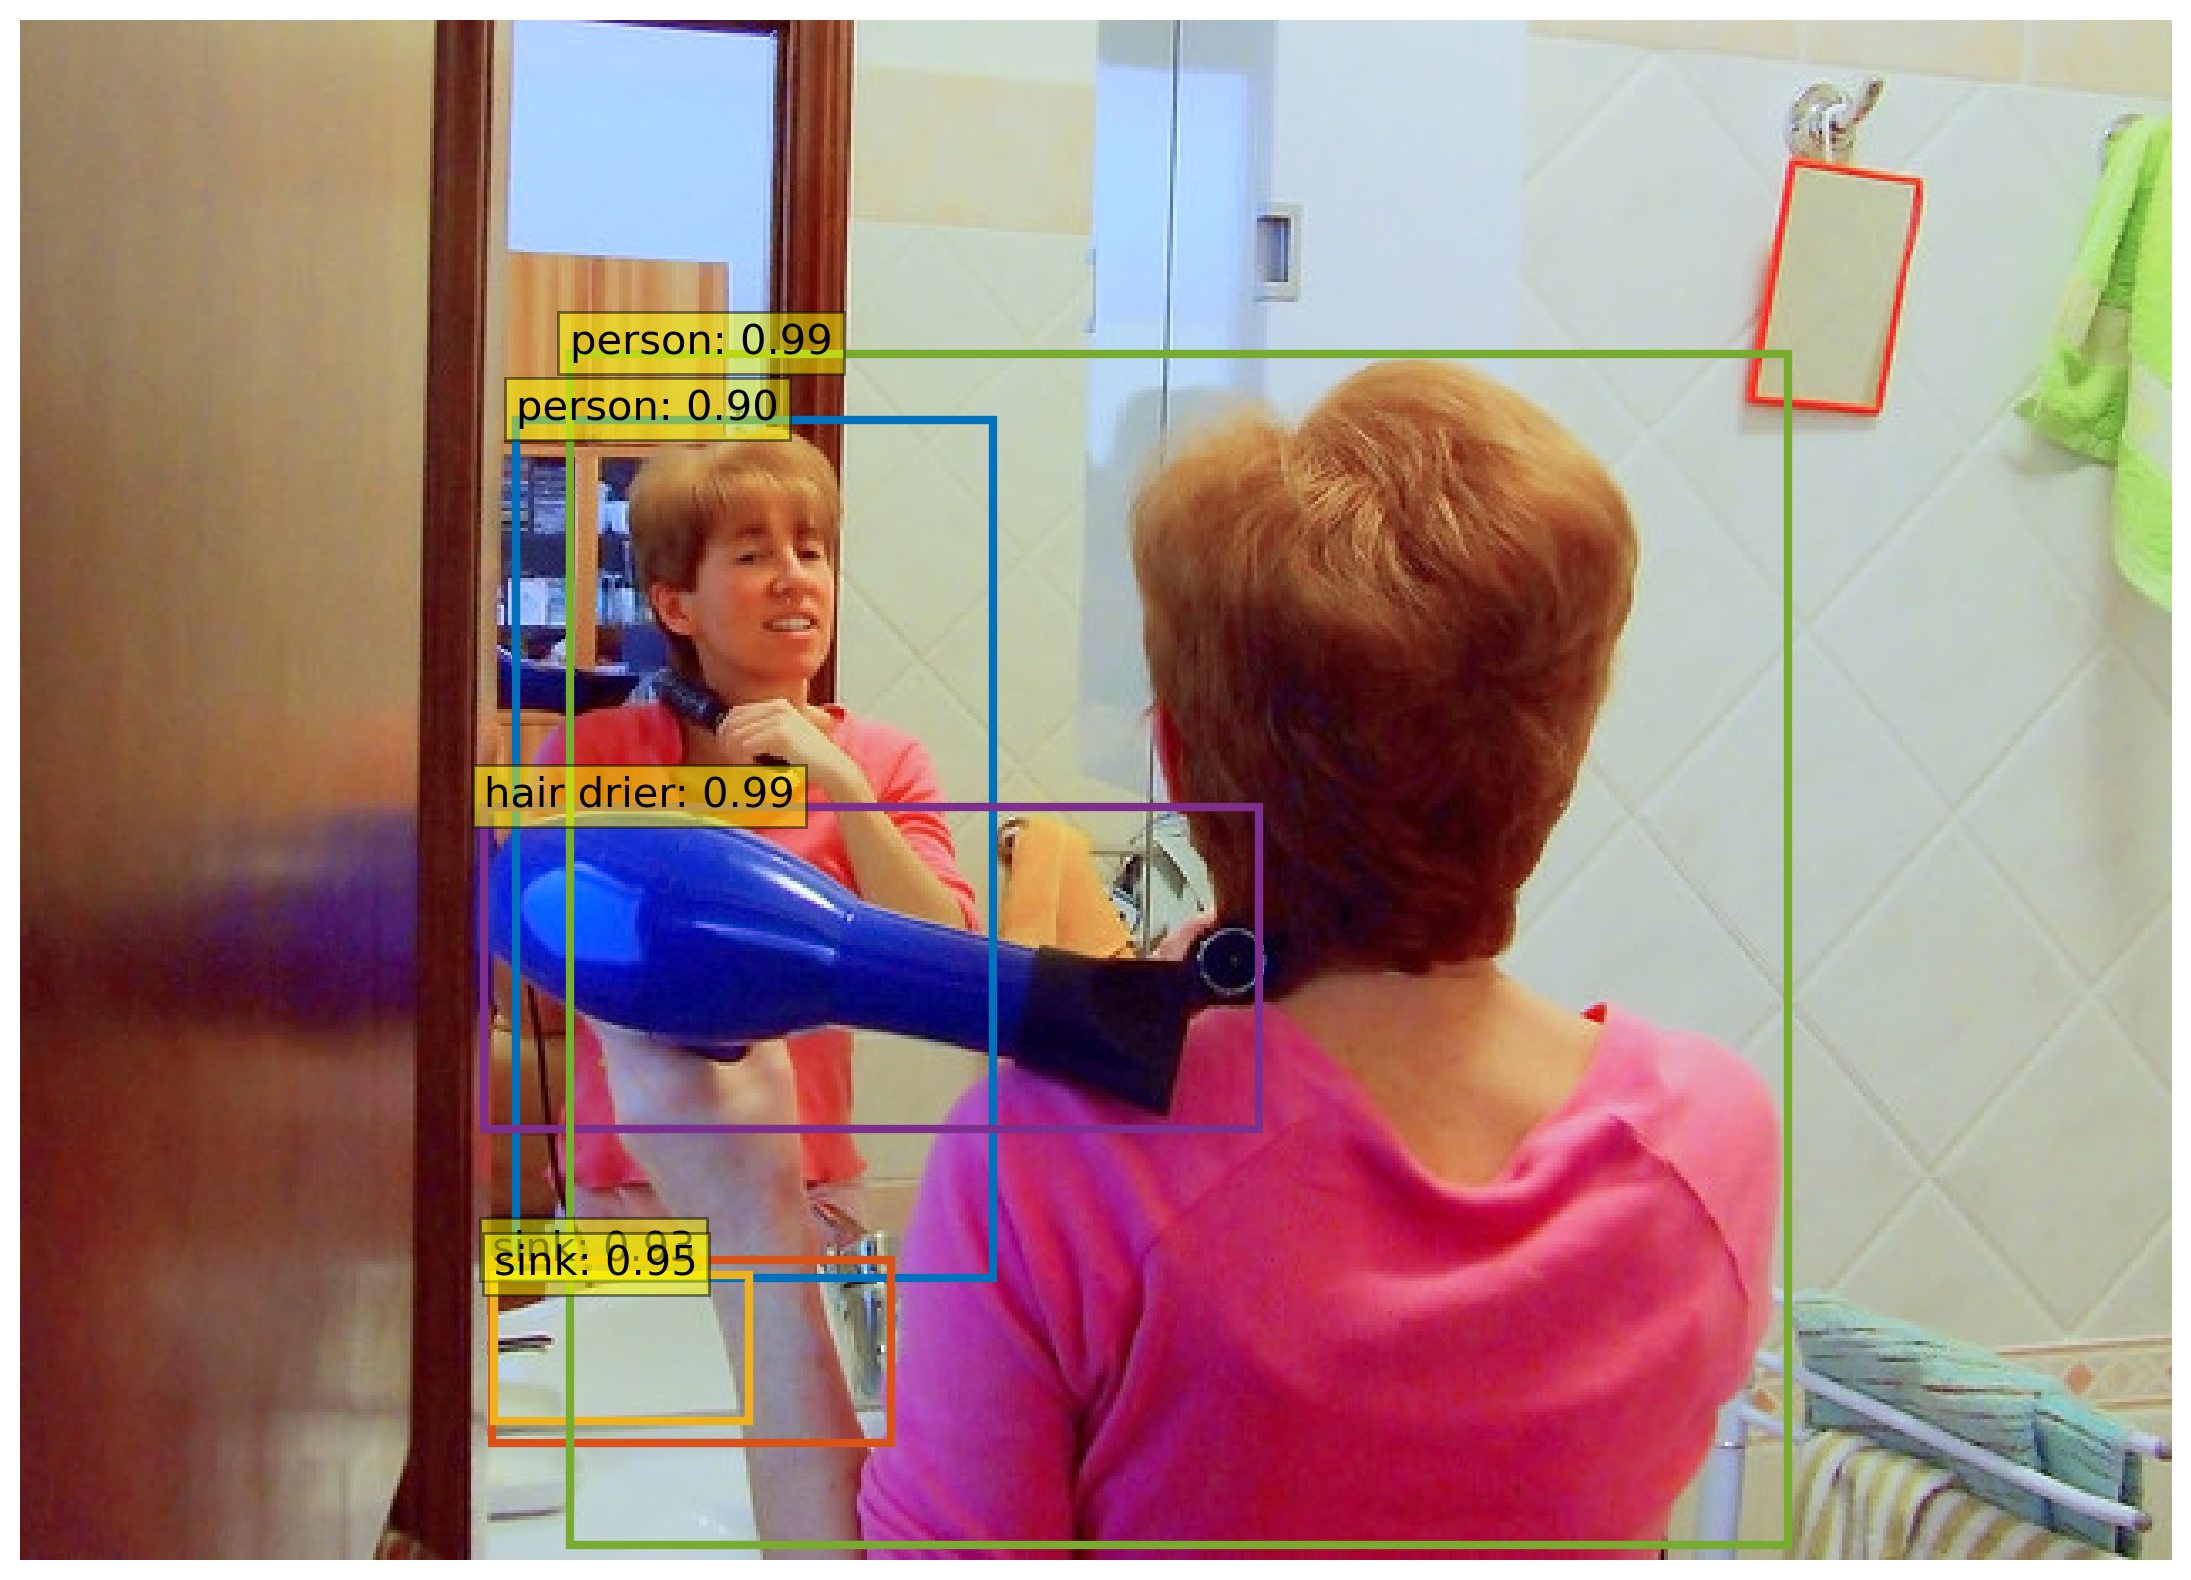

In [38]:
# TODO:
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

## 3.2 Visualizing Attention Maps [5%]

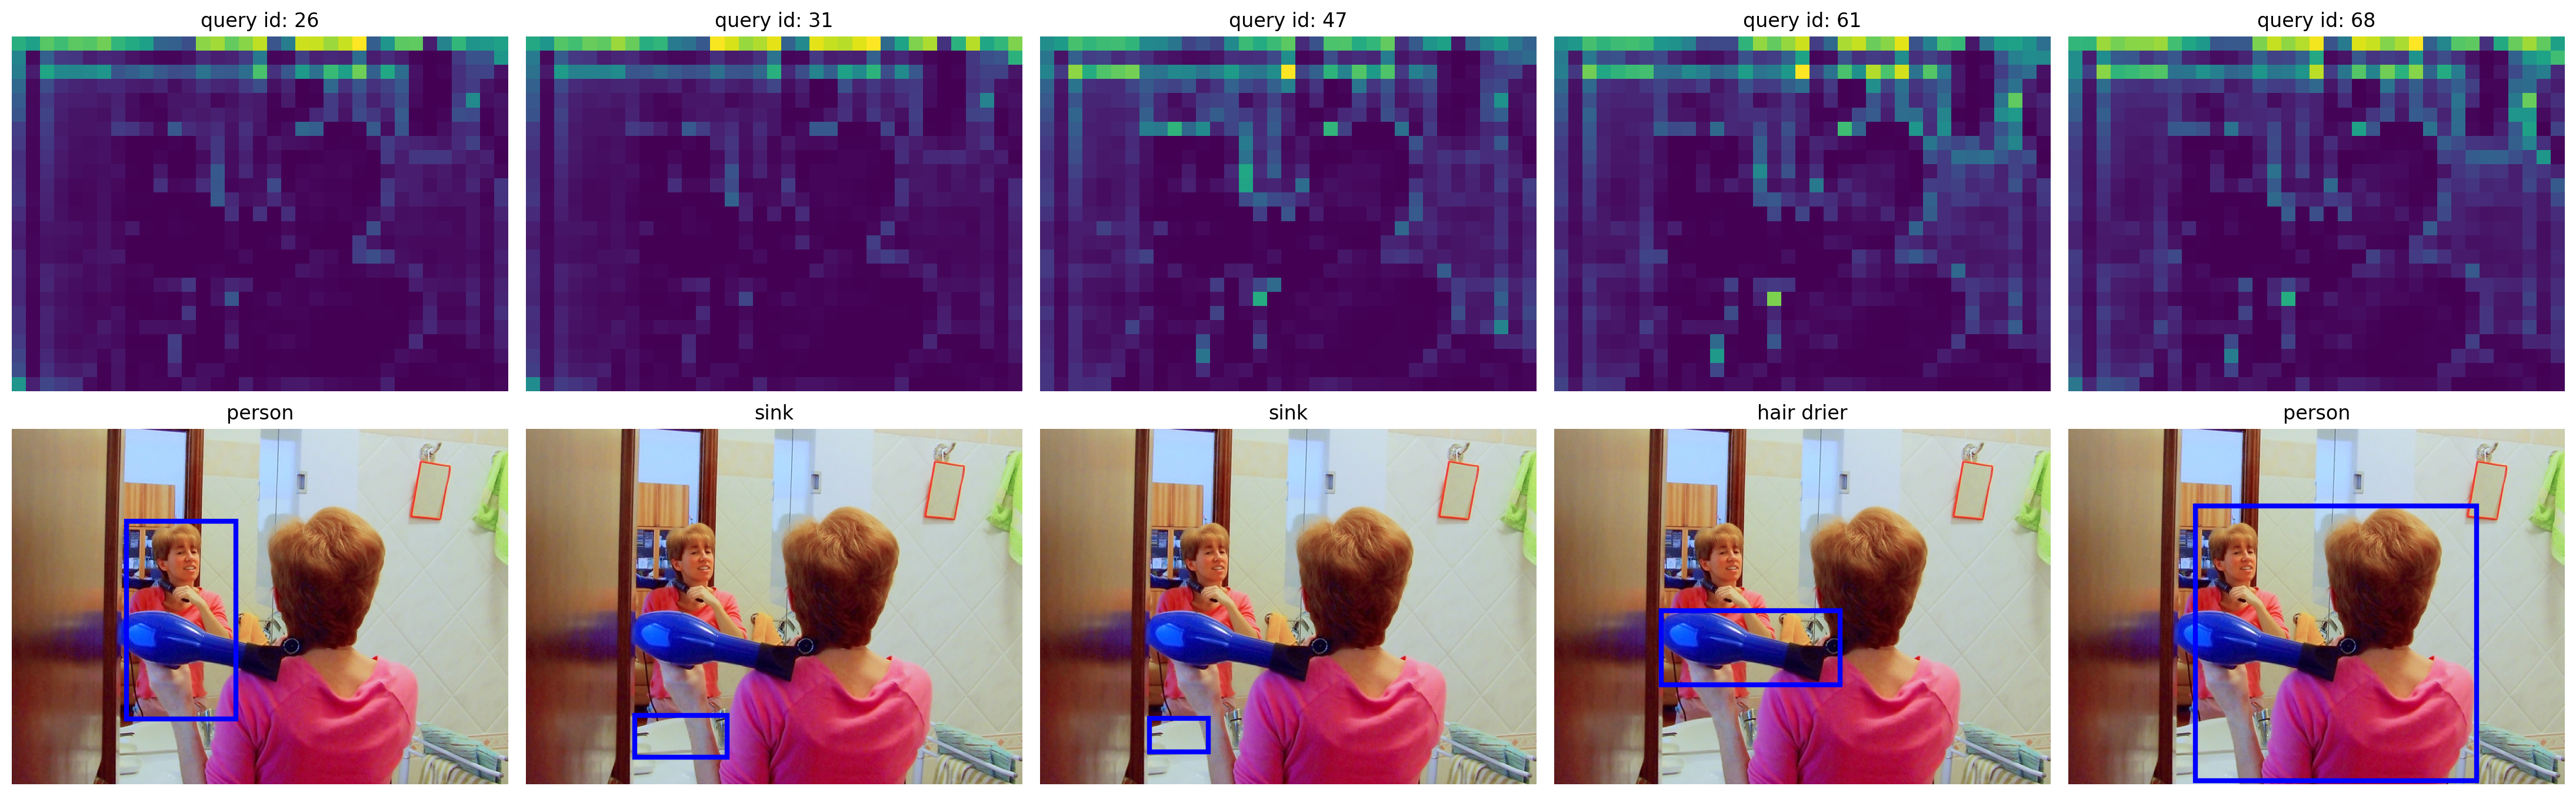

In [39]:
# TODO:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

# TODO:
hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[0].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[0].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# TODO: propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# TODO: Pop the elements
conv_features = conv_features.pop(0) if conv_features else None
enc_attn_weights = enc_attn_weights.pop(0) if enc_attn_weights else None
dec_attn_weights = dec_attn_weights.pop(0) if dec_attn_weights else None

# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(enc_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

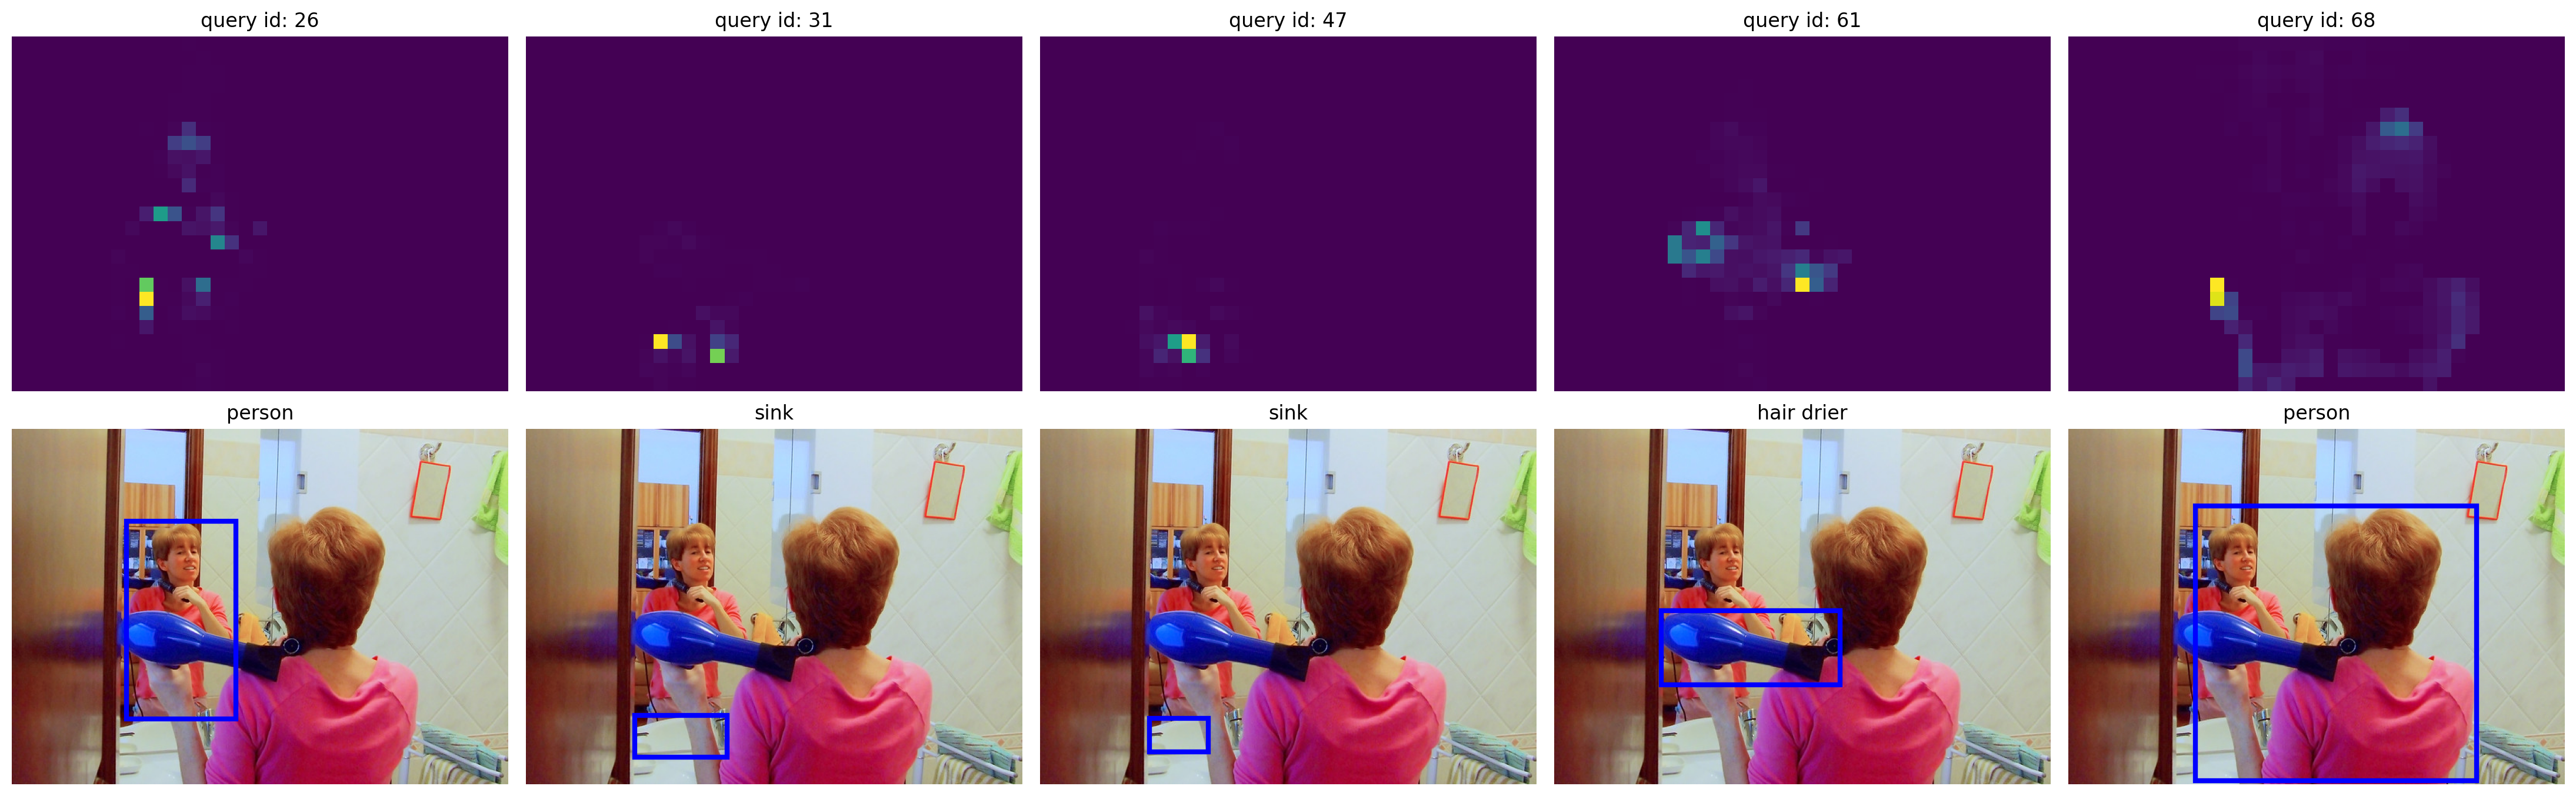

In [40]:
#plot for decoder

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

# 4. What do you observe? How do the visualizations using the 2 different backbones compare? [35%]

Give your insights in a maximum of 100 words

`Answer`

Here we are using the resnet101 backbone to predict the objects in the picture, which is supposed to be better than resnet50. We can see that the shape is more clear since resnet101 has more layers compared to resnet50, and in the heat map the shape of person is lighter and more identifiable. Also, resnet101 is able to detect the sink while resnet50 is unable to do so due to a lack of layers and ability to extract semantic information. However, we can also see that it misclassified two "sinks" inside the picture that overlaps. This means that resnet101 also has some misclassifications. On the other hand, on COCO, the person inside the mirror is not identified as another person, which is different from both backbones. 

